<a href="https://colab.research.google.com/github/jaspreetcodes/DSA1/blob/main/vggChestXRay2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
tf.device('/device:GPU:0')


In [ ]:
# os.chdir('content/')
os.getcwd()

'/content'

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d nih-chest-xrays/data

100% 42.0G/42.0G [37:52<00:00, 21.8MB/s]
100% 42.0G/42.0G [37:52<00:00, 19.8MB/s]


In [ ]:
!unzip data.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/images_012/images/00028897_016.png  
  inflating: dataset/images_012/images/00028897_017.png  
  inflating: dataset/images_012/images/00028897_018.png  
  inflating: dataset/images_012/images/00028897_019.png  
  inflating: dataset/images_012/images/00028897_020.png  
  inflating: dataset/images_012/images/00028898_000.png  
  inflating: dataset/images_012/images/00028899_000.png  
  inflating: dataset/images_012/images/00028899_001.png  
  inflating: dataset/images_012/images/00028899_002.png  
  inflating: dataset/images_012/images/00028900_000.png  
  inflating: dataset/images_012/images/00028901_000.png  
  inflating: dataset/images_012/images/00028901_001.png  
  inflating: dataset/images_012/images/00028902_000.png  
  inflating: dataset/images_012/images/00028902_001.png  
  inflating: dataset/images_012/images/00028902_002.png  
  inflating: dataset/images_012/images/00028902_003.png  
  inflating: dataset/

In [ ]:
os.listdir()
# path2 = 'dataset/Data_Entry_2017.csv'

['.config', 'data.zip', 'dataset', 'kaggle.json', 'sample_data']

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.utils import shuffle
#edit
df = pd.read_csv('dataset/Data_Entry_2017.csv')

diseases = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
#Number diseases
for disease in diseases :
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)


In [ ]:
os.listdir('dataset/')

['ARXIV_V5_CHESTXRAY.pdf',
 'images_003',
 'images_001',
 'images_010',
 'images_008',
 'FAQ_CHESTXRAY.pdf',
 'test_list.txt',
 'README_CHESTXRAY.pdf',
 'images_004',
 'LOG_CHESTXRAY.pdf',
 'images_011',
 'images_005',
 'train_val_list.txt',
 'images_007',
 'BBox_List_2017.csv',
 'Data_Entry_2017.csv',
 'images_006',
 'images_012',
 'images_009',
 'images_002']

In [ ]:
import os
#edit
labels = df[diseases].to_numpy()
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('dataset','images*','images','*.png'))}
print('Images found:', len(all_image_paths))


df['Path'] = df['Image Index'].map(all_image_paths.get)
files_list = df['Path'].tolist()

# #test to perfect
# labelB = df['Emphysema'].tolist()

labelB = (df[diseases].sum(axis=1)>0).tolist()
labelB = np.array(labelB, dtype=int)


Images found: 112120


In [ ]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path, shape):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=shape)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)/255
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, shape):
    list_of_tensors = [path_to_tensor(img_path, shape) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_labels = labelB[:89600][:, np.newaxis]
valid_labels = labelB[89600:100800][:, np.newaxis]
test_labels = labelB[100800:][:, np.newaxis]

img_shape = (64, 64)
train_tensors = paths_to_tensor(files_list[:89600], shape = img_shape)
valid_tensors = paths_to_tensor(files_list[89600:100800], shape = img_shape)
test_tensors = paths_to_tensor(files_list[100800:], shape = img_shape)

100%|██████████| 11320/11320 [02:54<00:00, 65.01it/s]


In [ ]:
import time

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.layers import Normalization
from keras import regularizers, applications, optimizers, initializers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

# VGG16
# resnet50.ResNet50
# inception_v3.InceptionV3 299x299
# inception_resnet_v2.InceptionResNetV2 299x299

base_model = VGG16(weights='imagenet',
                                include_top=False,
                                input_shape=train_tensors.shape[1:])

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.2))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(50, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
from keras import backend as K

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score

In [ ]:
# import tensorflow as tf

# Define a learning rate schedule with decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=500,  # Adjust this based on your problem
    decay_rate=0.9
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       precision_threshold(threshold=0.5),
                       recall_threshold(threshold=0.5),
                       fbeta_score_threshold(beta=0.5, threshold=0.5)])


# import keras.backend as K
# import tensorflow as tf

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6),
#               loss='binary_crossentropy',
#               metrics=['accuracy',
#                       precision_threshold(threshold = 0.5),
#                        recall_threshold(threshold = 0.5),
#                        fbeta_score_threshold(beta=0.5, threshold = 0.5)])

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import numpy as np

epochs = 20
batch_size = 32

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto')
log = CSVLogger('saved_models/log_pretrained_CNN.csv')
checkpointer = ModelCheckpoint(filepath='saved_models/pretrainedVGG.best.from_scratch.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

start = time.time()
train_datagen = ImageDataGenerator(
                        featurewise_center=False,  # set input mean to 0 over the dataset
                        samplewise_center=False,  # set each sample mean to 0
                        featurewise_std_normalization=False,  # divide inputs by std of the dataset
                        samplewise_std_normalization=False,  # divide each input by its std
                        zca_whitening=False,  # apply ZCA whitening
                        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                        horizontal_flip=True,  # randomly flip images
                        vertical_flip=False
)
history = model.fit_generator(
    train_datagen.flow(train_tensors,train_labels, batch_size = batch_size),
    steps_per_epoch = len(train_tensors) // batch_size,
    validation_data = (valid_tensors, valid_labels),
    validation_steps = len(valid_tensors) // batch_size,
    epochs = epochs,
    callbacks=[checkpointer, log], verbose=1
)
print("training time: %.2f minutes"%((time.time()-start)/60))

Epoch 1/20


<ipython-input-32-ee549ae7890c>:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


2800/2800 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.6811 - precision: 0.6702 - recall: 0.6217
Epoch 1: val_accuracy improved from -inf to 0.70170, saving model to saved_models/pretrainedVGG.best.from_scratch.hdf5
2800/2800 [==============================] - 113s 39ms/step - loss: 0.6108 - accuracy: 0.6811 - precision: 0.6702 - recall: 0.6217 - val_loss: 0.5850 - val_accuracy: 0.7017 - val_precision: 0.5737 - val_recall: 0.4918
Epoch 2/20
2799/2800 [============================>.] - ETA: 0s - loss: 0.5955 - accuracy: 0.6960 - precision: 0.6821 - recall: 0.6401
Epoch 2: val_accuracy improved from 0.70170 to 0.70884, saving model to saved_models/pretrainedVGG.best.from_scratch.hdf5
2800/2800 [==============================] - 109s 39ms/step - loss: 0.5955 - accuracy: 0.6961 - precision: 0.6821 - recall: 0.6402 - val_loss: 0.5817 - val_accuracy: 0.7088 - val_precision: 0.5872 - val_recall: 0.4504
Epoch 3/20
2799/2800 [============================>.] - ETA: 0s 

In [ ]:
model.load_weights('saved_models/pretrainedVGG.best.from_scratch.hdf5')
prediction = model.predict(test_tensors)

354/354 [==============================] - 2s 5ms/step


In [ ]:
threshold = 0.5
beta = 0.5

pre = K.eval(precision_threshold(threshold = threshold)(K.variable(value=test_labels),K.variable(value=prediction)))
rec = K.eval(recall_threshold(threshold = threshold)(K.variable(value=test_labels),K.variable(value=prediction)))
#fsc = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value=test_labels),
                                   #K.variable(value=prediction)))

print ("Precision: %f %%\nRecall: %f "% (pre, rec))

Precision: 0.685331 %
Recall: 0.673827 


In [ ]:
K.eval(binary_accuracy(K.variable(value=test_labels),
                       K.variable(value=prediction)))

0.6889576

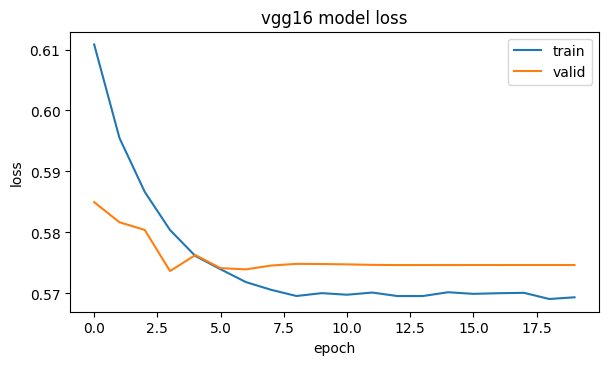

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (15,8))

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('vgg16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

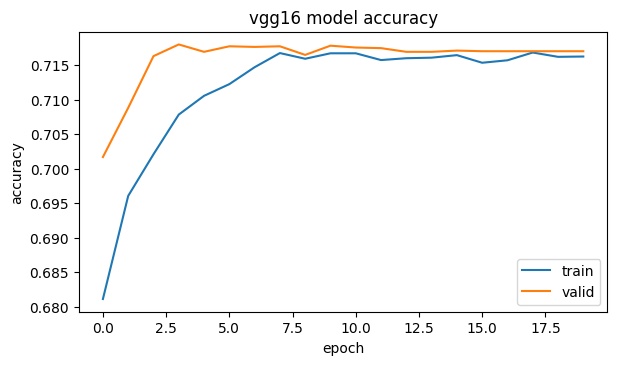

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(222)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('vgg16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

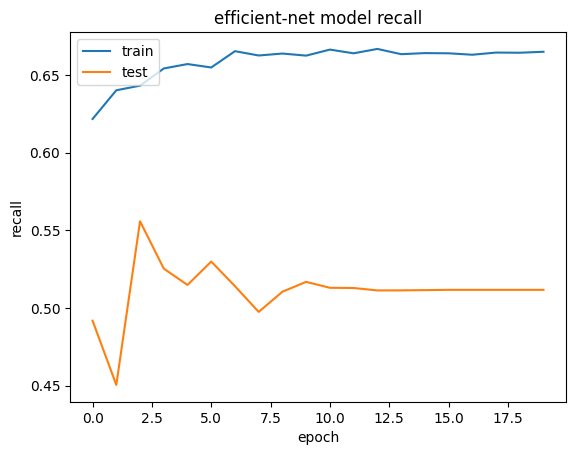

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

plt.title('efficient-net model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

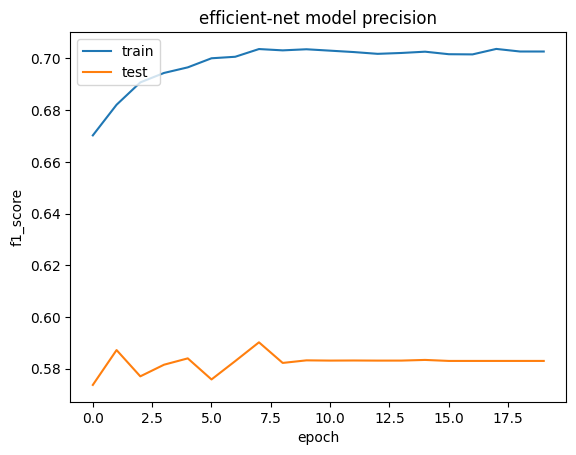

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])

plt.title('efficient-net model precision')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("vgg16_adam.h5")
model.save_weights('vgg16_weights_adam.h5')

In [ ]:
pred = model.predict(test_tensors)


354/354 [==============================] - 1s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

true_labels = ...  # Extract true labels from your dataset


In [ ]:
pred = np.argmax(pred,axis=1)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_curve, auc


print('Accuracy:')

Accuracy:


In [ ]:
x = accuracy_score (pred,test_labels)

In [ ]:
print('\nClassification Report:')
print(classification_report(pred,test_labels))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.51      0.68     11320
           1       0.00      0.00      0.00         0

    accuracy                           0.51     11320
   macro avg       0.50      0.26      0.34     11320
weighted avg       1.00      0.51      0.68     11320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('\nConfusion Matrix::')
print(confusion_matrix(test_labels,pred))


Confusion Matrix::
[[5780    0]
 [5540    0]]


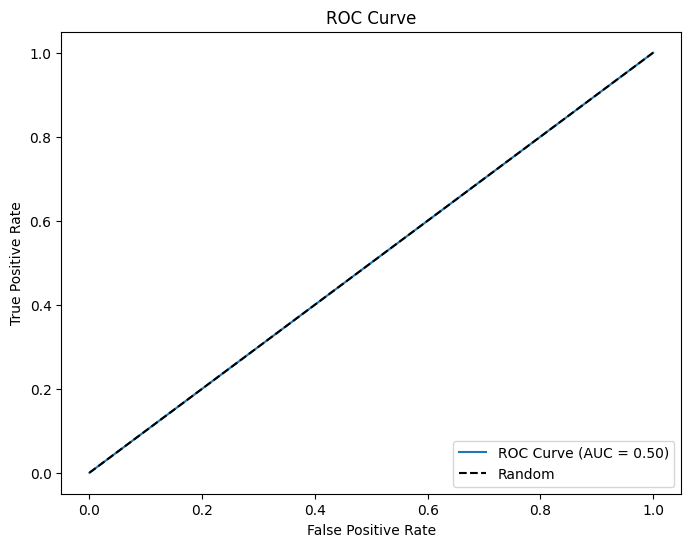

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, pred)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# from sklearn.preprocessing import label_binarize

# # Binarize the true labels for a multi-class problem
# true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plotting ROC curve
# plt.figure(figsize=(8, 6))

# for i in range(num_classes):
#     plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# plt.plot([0, 1], [0, 1], 'k--', label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - One vs Rest')
# plt.legend(loc='lower right')
# plt.show()

NameError: ignored

In [ ]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # Assuming 'model' is your trained VGG16 model and 'test_tensors', 'test_labels' are your test data
# # Make sure to load the model and test data before running this code

# # Predict probabilities for each class
# y_score = model.predict(test_tensors)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(len(diseases)):
#     fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves
# plt.figure(figsize=(10, 8))
# for i in range(len(diseases)):
#     plt.plot(fpr[i], tpr[i], label=f'{diseases[i]} (AUC = {roc_auc[i]:.2f})')

# plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve for NIH Chest X-ray Disease Classification')
# plt.legend(loc="lower right")
# plt.show()


354/354 [==============================] - 1s 4ms/step


IndexError: ignored

NameError: ignored

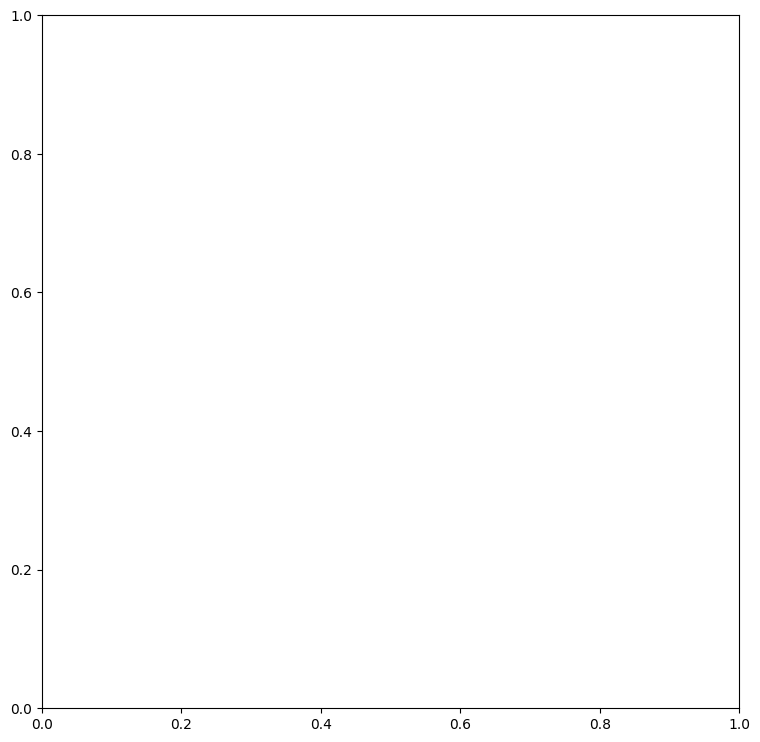

In [ ]:
# fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
# for (idx, c_label) in enumerate(labels):
#     fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
#     c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
# c_ax.legend()
# c_ax.set_xlabel('False Positive Rate')
# c_ax.set_ylabel('True Positive Rate')
# fig.savefig('trained_net.png')

In [ ]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # Assuming 'vgg_model' is your trained VGG16 model and 'test_tensors', 'test_labels' are your test data
# # Make sure to load the model and test data before running this code

# # Predict probabilities for each class
# y_score = vgg_model.predict(test_generator, steps=np.ceil(len(test_df)/BATCH_SIZE))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(len(labels)):
#     fpr[i], tpr[i], _ = roc_curve(test_df['Gender'].astype(int), y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves
# plt.figure(figsize=(9, 9))
# for i in range(len(labels)):
#     plt.plot(fpr[i], tpr[i], label='%s (AUC:%0.2f)' % (labels[i], roc_auc[i]))

# plt.legend()
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve for NIH Chest X-ray Gender Classification')
# plt.savefig('trained_net.png')
# plt.show()



NameError: ignored